## Question 1

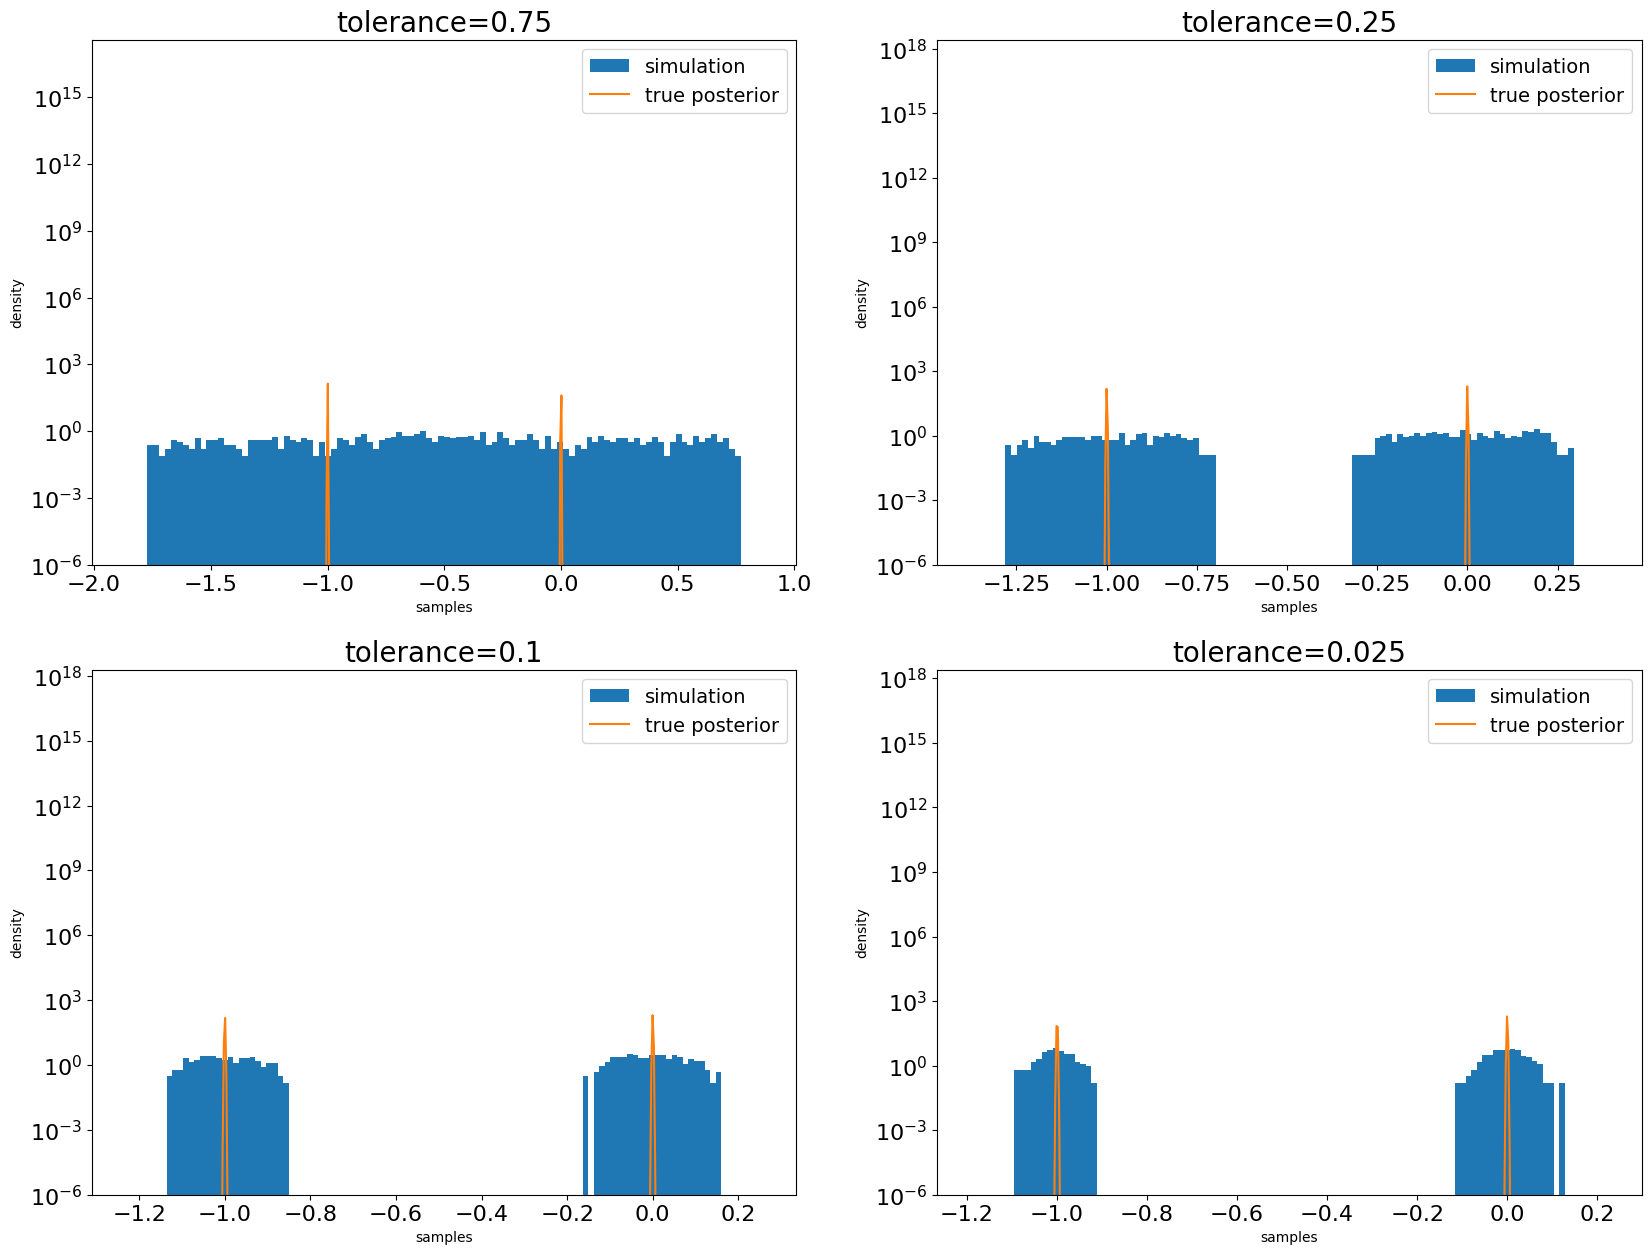

In [1]:
import numpy as np
from example import example_tolerances, ExamplePosteriorModel, example_M, example_mean, example_a, example_sigma, example_sigma_1, example_N, plot_ex_samples

posterior_model = ExamplePosteriorModel(example_M, example_mean, example_a, example_sigma, example_sigma_1)
tolerance_samples = []

for tolerance in example_tolerances:
    tolerance_samples.append(np.load(f"data/ex/q1/ex_q1_[tol={tolerance}]_[N={example_N}].npy"))

plot_ex_samples(tolerance_samples, posterior_model, example_tolerances, set_log=True, set_ylim=1e-6, save_path="data/ex/q1/figures/ex_q1.pdf")

## Question 2

## Question 3

In [2]:
import numpy as np
from example import example_tolerances, ExamplePosteriorModel, example_M, example_mean, example_a, example_sigma, example_sigma_1, example_N, plot_ex_samples

posterior_model = ExamplePosteriorModel(example_M, example_mean, example_a, example_sigma, example_sigma_1)
proposal_vars = [0.5, 1, 2, 4, 8]

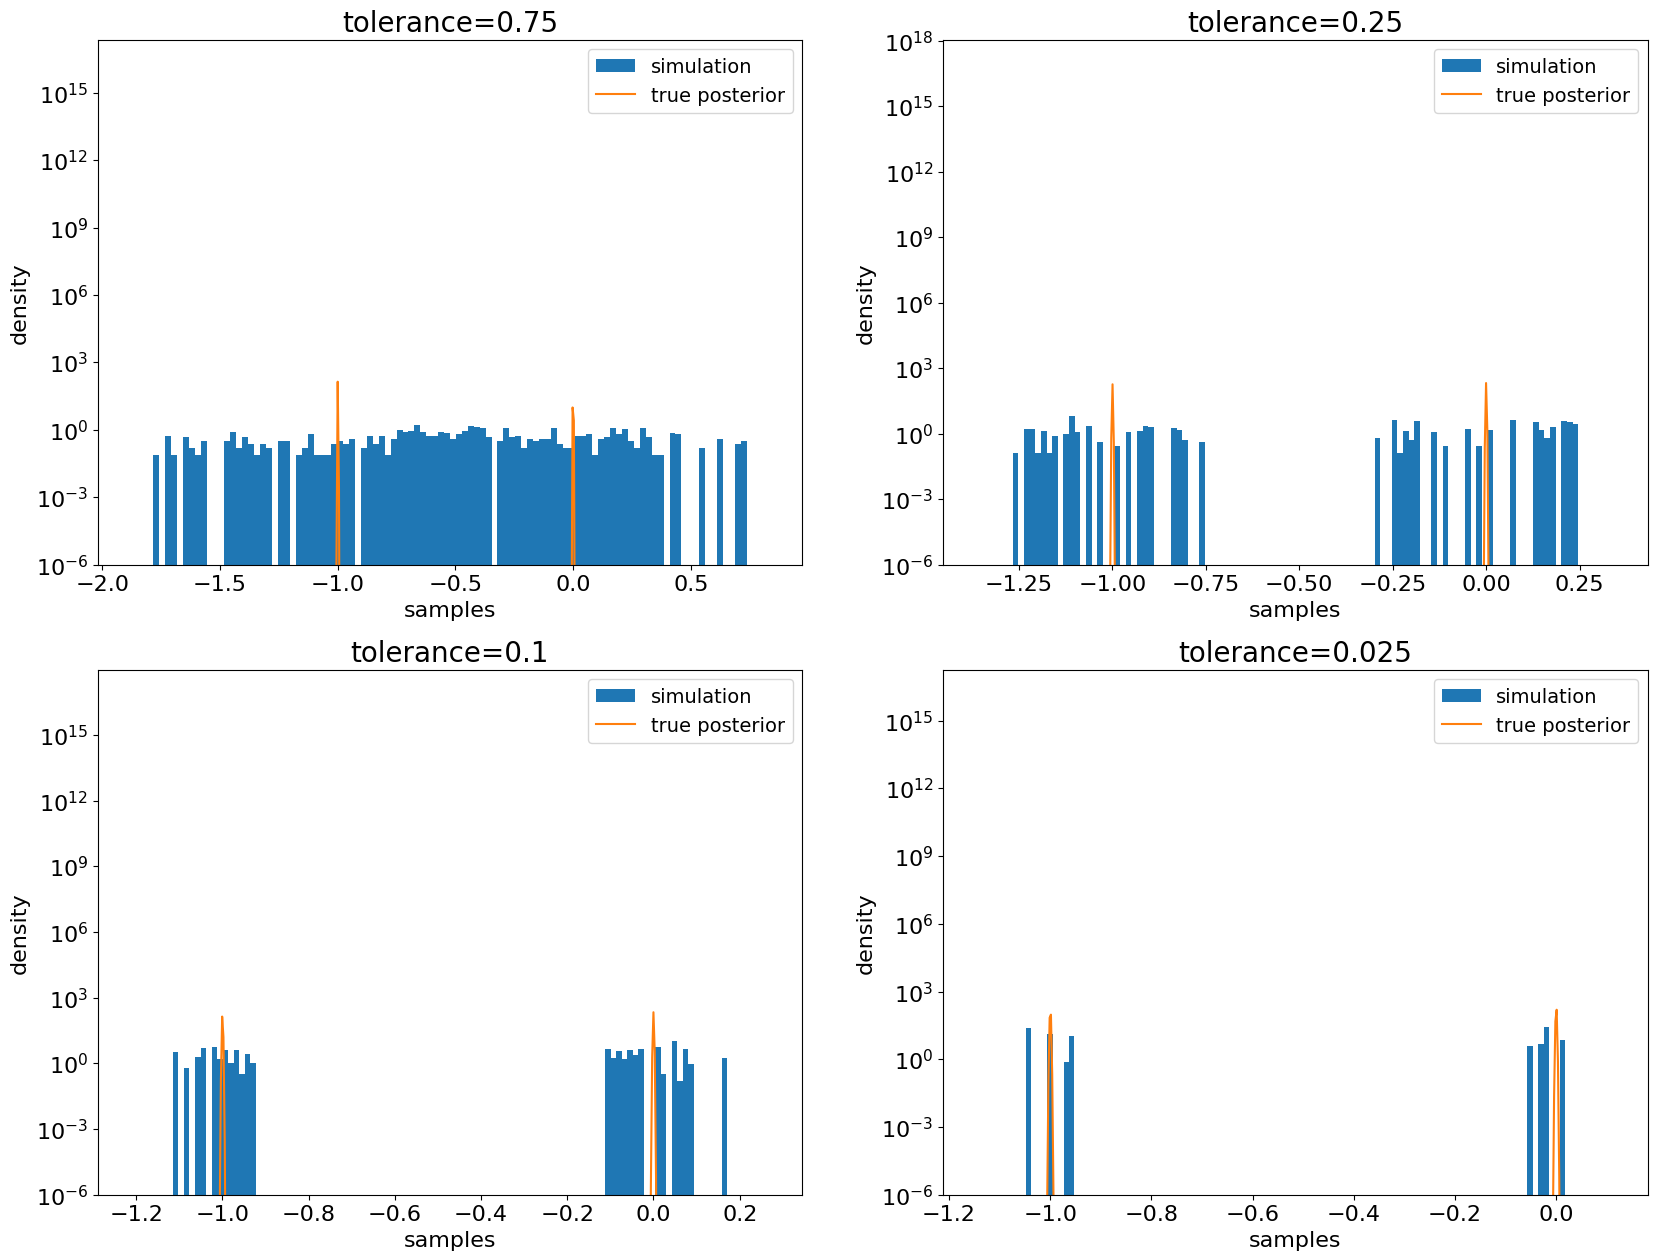

In [3]:
tolerance_samples = []
for tolerance in example_tolerances:
    tolerance_samples.append(np.load(f"data/ex/q3/ex_q3_[pvar={proposal_vars[0]}]_[tol={tolerance}]_[N={example_N}].npy"))

plot_ex_samples(tolerance_samples, posterior_model, example_tolerances, set_log=True, set_ylim=1e-6, save_path=f"data/ex/q3/figures/ex_q3_pvar{proposal_vars[0]}.pdf")

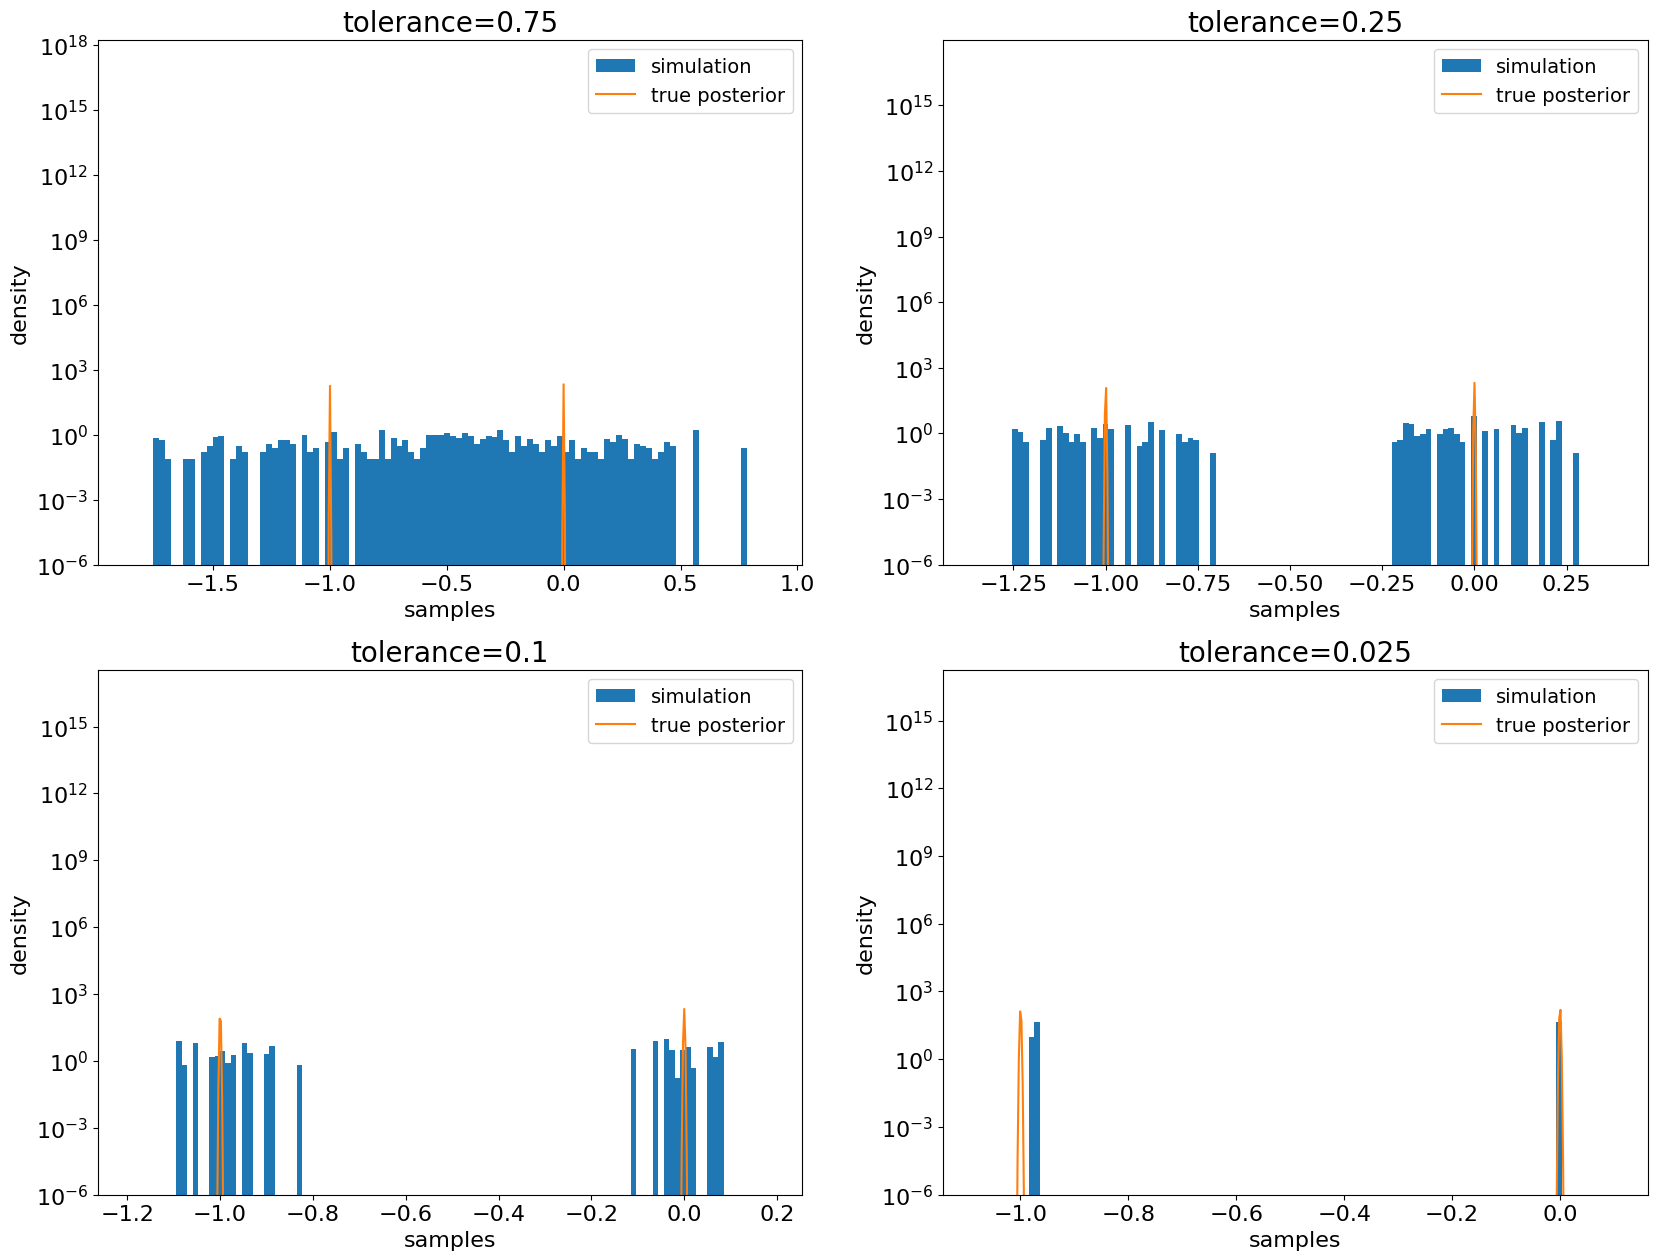

In [4]:
tolerance_samples = []
for tolerance in example_tolerances:
    tolerance_samples.append(np.load(f"data/ex/q3/ex_q3_[pvar={proposal_vars[1]}]_[tol={tolerance}]_[N={example_N}].npy"))

plot_ex_samples(tolerance_samples, posterior_model, example_tolerances, set_log=True, set_ylim=1e-6, save_path=f"data/ex/q3/figures/ex_q3_pvar{proposal_vars[1]}.pdf")

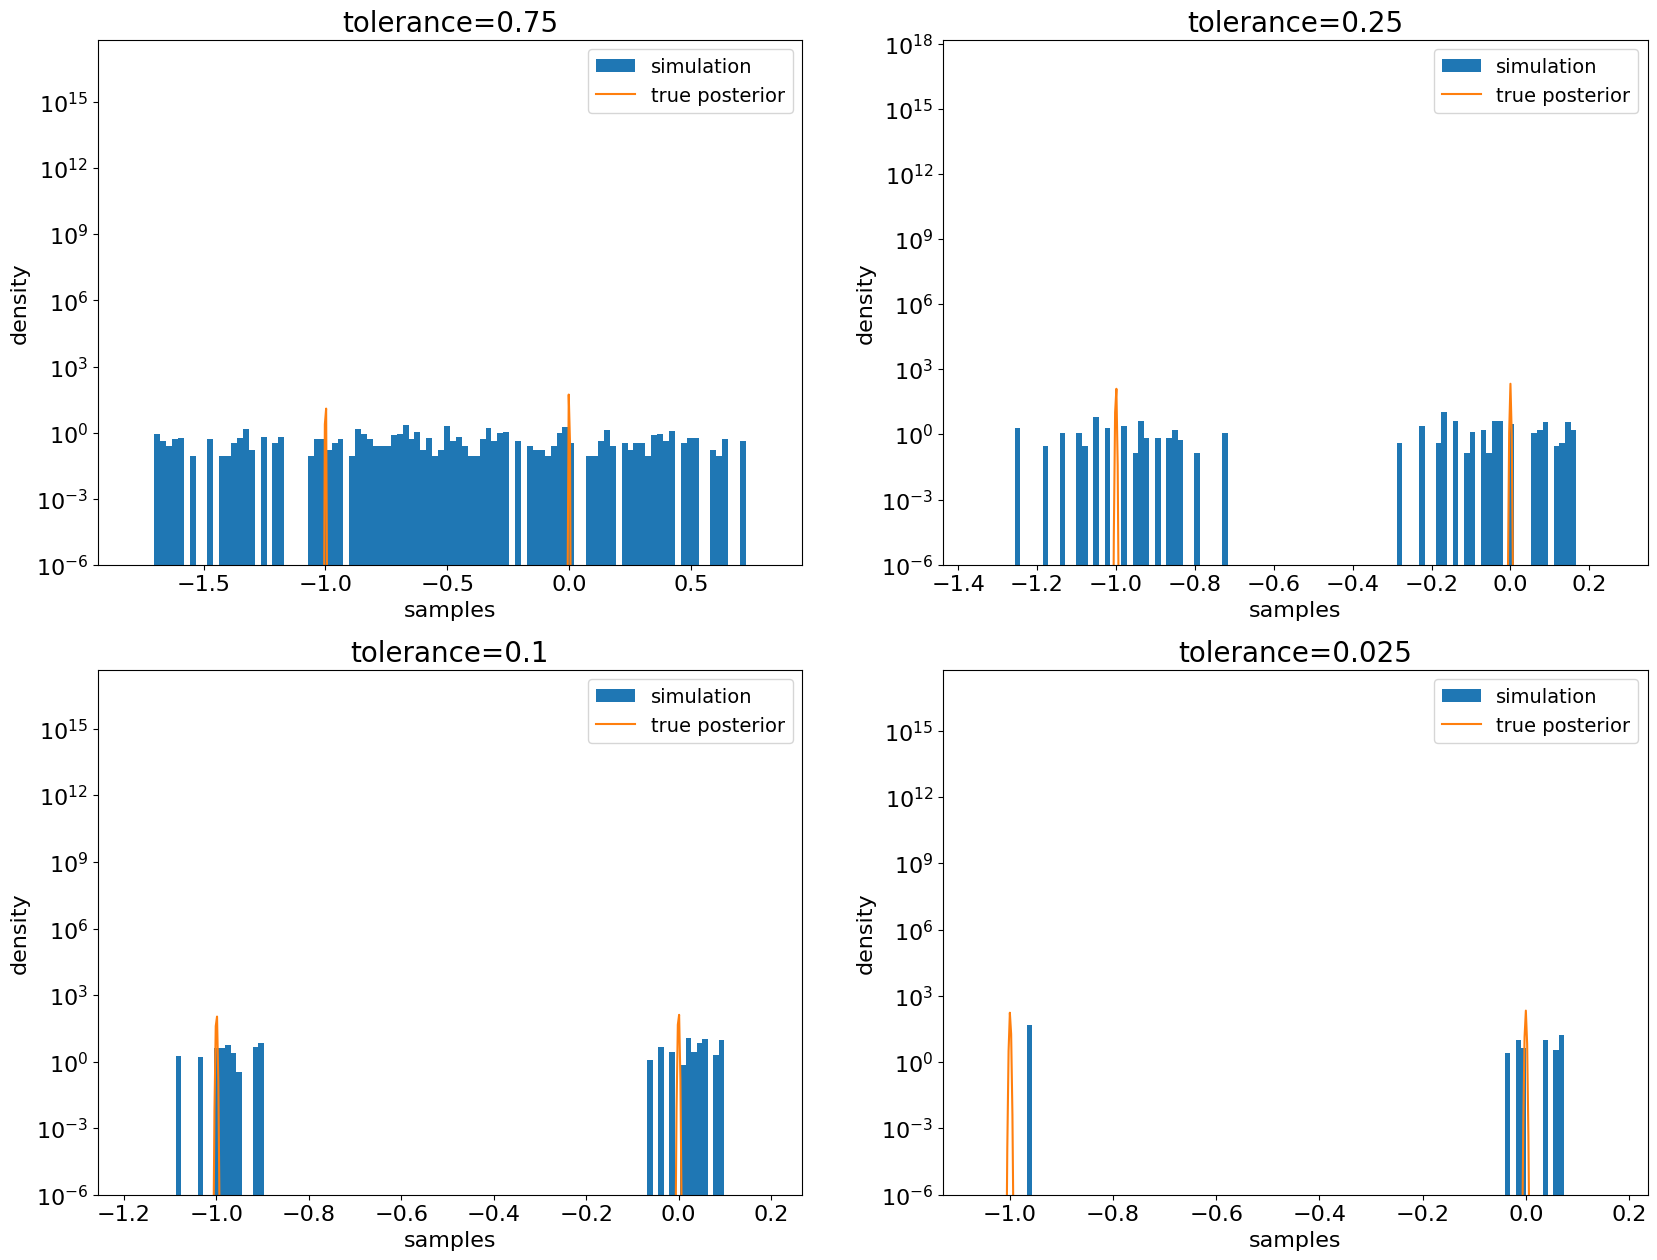

In [5]:
tolerance_samples = []
for tolerance in example_tolerances:
    tolerance_samples.append(np.load(f"data/ex/q3/ex_q3_[pvar={proposal_vars[2]}]_[tol={tolerance}]_[N={example_N}].npy"))

plot_ex_samples(tolerance_samples, posterior_model, example_tolerances, set_log=True, set_ylim=1e-6, save_path=f"data/ex/q3/figures/ex_q3_pvar{proposal_vars[2]}.pdf")

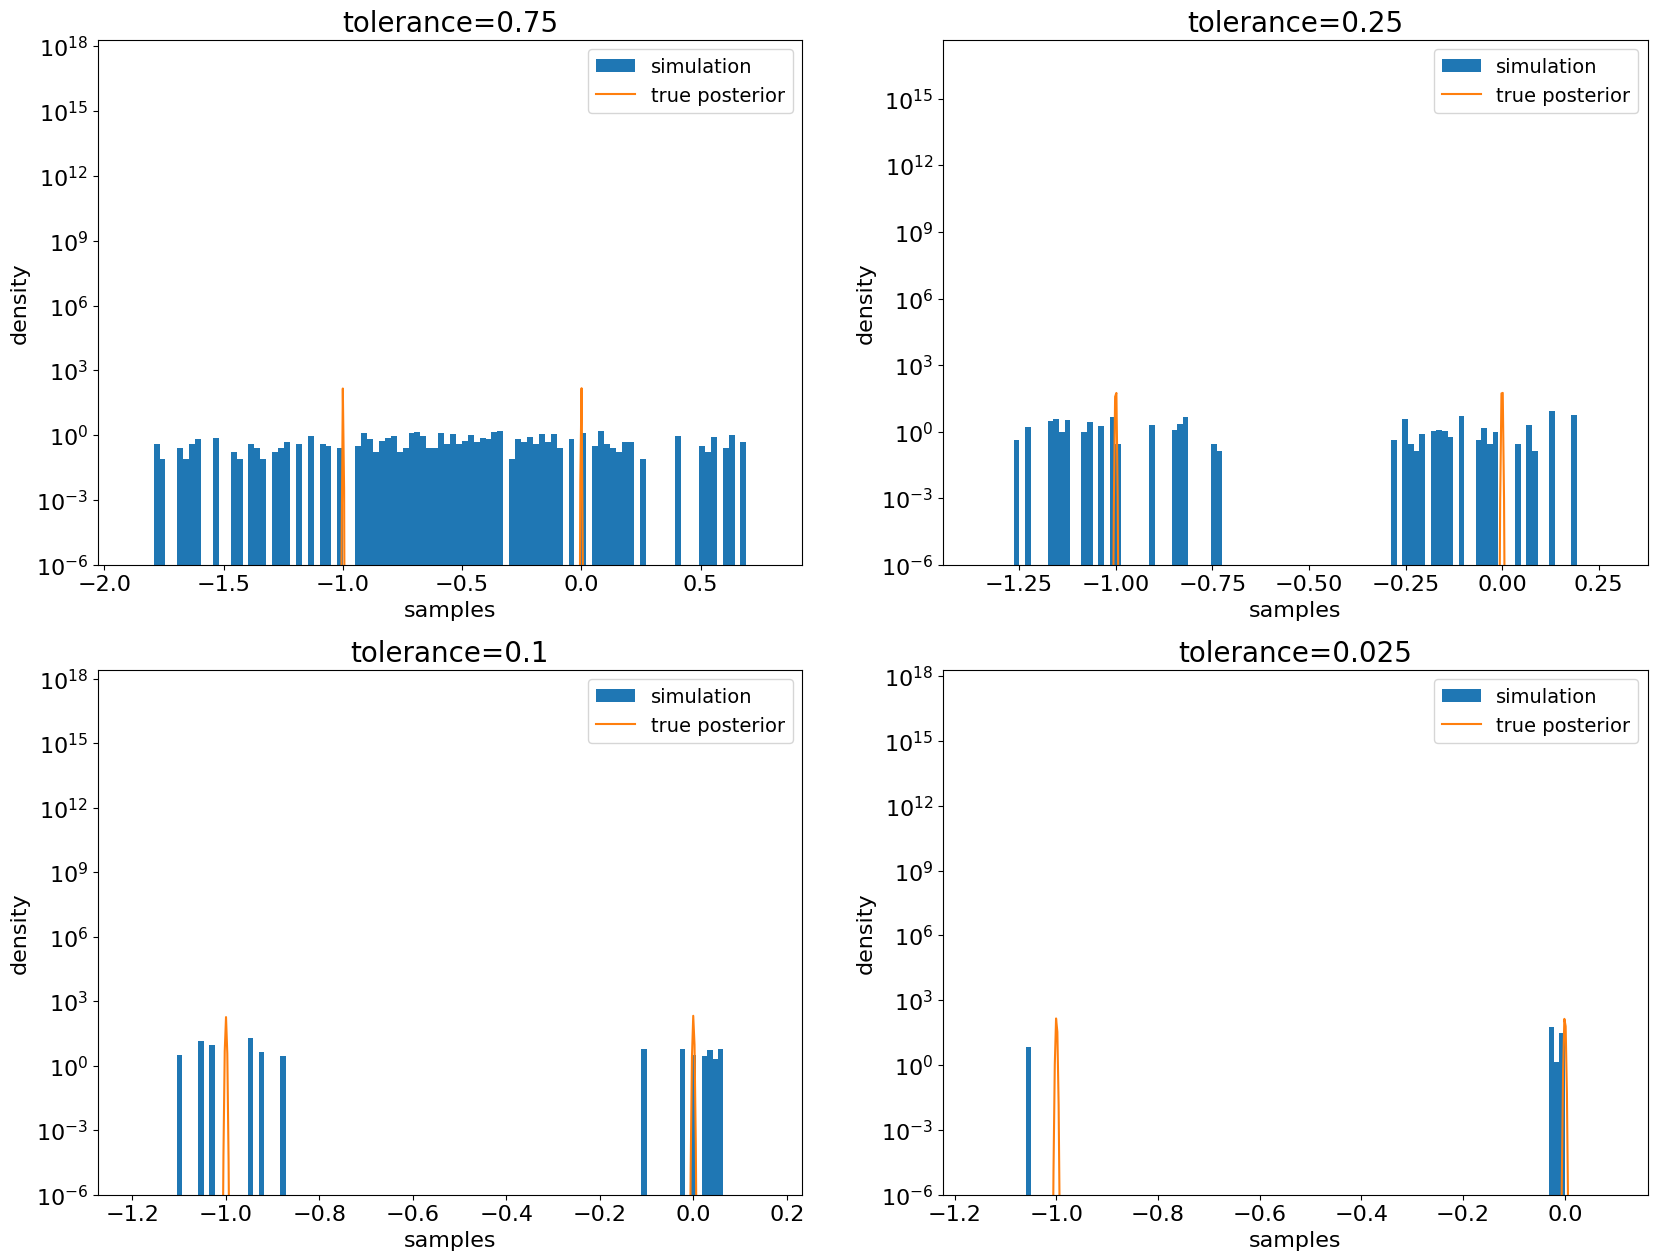

In [7]:
tolerance_samples = []
for tolerance in example_tolerances:
    tolerance_samples.append(np.load(f"data/ex/q3/ex_q3_[pvar={proposal_vars[3]}]_[tol={tolerance}]_[N={example_N}].npy"))

plot_ex_samples(tolerance_samples, posterior_model, example_tolerances, set_log=True, set_ylim=1e-6, save_path=f"data/ex/q3/figures/ex_q3_pvar{proposal_vars[3]}.pdf")

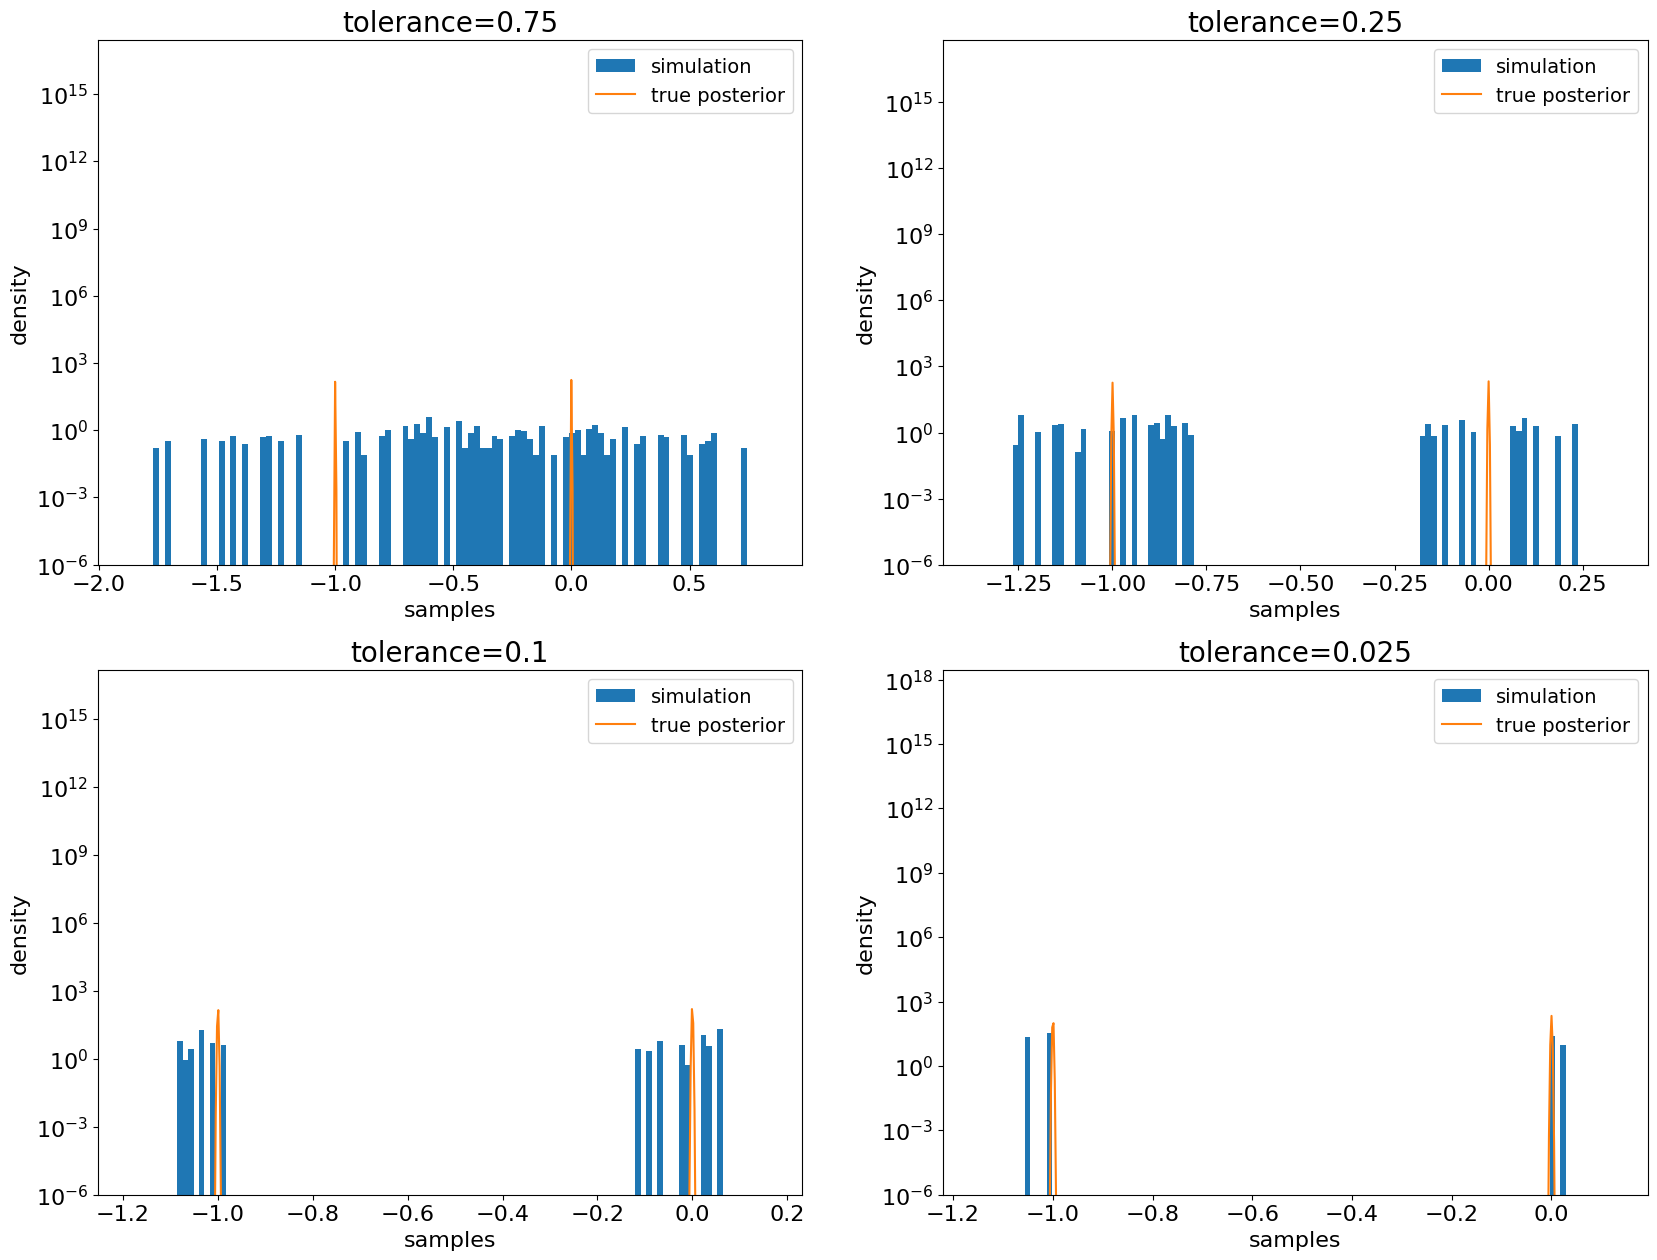

In [8]:
tolerance_samples = []
for tolerance in example_tolerances:
    tolerance_samples.append(np.load(f"data/ex/q3/ex_q3_[pvar={proposal_vars[4]}]_[tol={tolerance}]_[N={example_N}].npy"))

plot_ex_samples(tolerance_samples, posterior_model, example_tolerances, set_log=True, set_ylim=1e-6, save_path=f"data/ex/q3/figures/ex_q3_pvar{proposal_vars[4]}.pdf")

## Question 4

In [24]:
import numpy as np

from pharmacokinetics import sampling_times

observed_data = np.load("data/ph/q4/ph_observed_data.npy")

for t, x_t in zip(sampling_times, observed_data):
    print(f"t={t}, x_t={x_t}")

t=0.25, x_t=2.3713967491565398
t=0.5, x_t=4.007209277296181
t=1, x_t=5.848125345897168
t=2, x_t=6.919312396940406
t=3.5, x_t=6.284713647332495
t=5, x_t=5.972213386710638
t=7, x_t=5.404302354208366
t=9, x_t=5.145666857219228
t=12, x_t=3.8791675076922667


In [27]:
import pandas as pd

from pharmacokinetics import train_size

train_df = pd.read_csv(f"data/ph/q4/ph_train_data_[size={train_size}].csv")

train_df.head()

,x_[t=0.25],x_[t=0.5],x_[t=1],x_[t=2],x_[t=3.5],x_[t=5],x_[t=7],x_[t=9],x_[t=12],K_a,K_e,Cl,sigma
0,0.410621,0.896078,1.850801,2.728832,2.091249,3.016270,3.605622,4.372277,3.342689,1.403102,0.061855,0.083589,0.525665
1,0.551929,1.007236,1.269937,1.732547,1.369315,1.402990,1.188815,0.211661,-0.746390,1.966361,0.030815,0.096693,0.424611
2,0.338219,0.460740,0.935708,1.127534,0.784874,0.601704,0.313522,0.042641,-0.311713,1.556742,0.021313,0.084379,0.261536
3,0.420919,0.494644,1.029335,0.762094,0.954759,0.943566,1.177974,1.199776,1.028796,1.441256,0.047130,0.172762,0.238268
4,1.138270,1.730856,2.282672,2.912130,2.750806,2.357045,1.237974,0.973370,0.675392,1.329735,0.049492,0.057598,0.434988


In [29]:
import pickle

k_a_model = pickle.load(open(f"data/ph/q4/ph_k_a_model_[size={train_size}].pkl", "rb"))
k_e_model = pickle.load(open(f"data/ph/q4/ph_k_e_model_[size={train_size}].pkl", "rb"))
cl_model = pickle.load(open(f"data/ph/q4/ph_cl_model_[size={train_size}].pkl", "rb"))
sigma_model = pickle.load(open(f"data/ph/q4/ph_sigma_model_[size={train_size}].pkl", "rb"))

print("Model summaries:")
print("\nK_a model:")
print(k_a_model.summary())
print("\nK_e model:")
print(k_e_model.summary())
print("\nCl model:")
print(cl_model.summary())
print("\nsigma model:")
print(sigma_model.summary())

Model summaries:

K_a model:
                            OLS Regression Results                            
Dep. Variable:                    K_a   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     86.74
Date:                Tue, 02 Jan 2024   Prob (F-statistic):          1.38e-118
Time:                        13:55:17   Log-Likelihood:                -408.99
No. Observations:                1000   AIC:                             838.0
Df Residuals:                     990   BIC:                             887.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2447  

In [30]:
coefficients = np.vstack([k_a_model.params, k_e_model.params, cl_model.params, sigma_model.params])
print("\nCoefficients:")
print(coefficients)


Coefficients:
[[ 1.24473971e+00  2.11121711e-01  1.32125142e-01  2.98293676e-02
  -1.42853830e-01 -1.20440869e-01  5.76011342e-02  7.22371554e-02
  -3.47865932e-02  1.29367189e-02]
 [ 6.92204674e-02  4.85107340e-03 -2.20043896e-03 -2.57172532e-03
   4.84081639e-03  3.69951581e-03  5.02673776e-03 -3.23633897e-03
  -4.42039677e-03 -9.81421015e-03]
 [ 1.11308453e-01 -9.57000574e-03  1.22907927e-03  6.17756286e-03
  -9.08672836e-04 -3.77665020e-03 -5.38961152e-05 -1.15662668e-03
   1.90929249e-03 -1.07225431e-02]
 [ 3.54565465e-01  5.84360163e-02 -4.24135857e-02 -6.49541011e-03
   1.52755716e-02 -1.95274827e-02  1.24946084e-02  1.19821132e-02
  -2.62841109e-03 -1.17030278e-02]]


## Question 5

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sample_0_25 = np.load("data/ph/q5/rw_lognorm/ph_rw_lognorm_[tol=0.25]_[N=10000].npy")
sample_0_7 = np.load("data/ph/q5/rw_lognorm/ph_rw_lognorm_[tol=0.7]_[N=10000].npy")
sample_1 = np.load("data/ph/q5/rw_lognorm/ph_rw_lognorm_[tol=1]_[N=10000].npy")
ph_tolerances = [0.25, 0.7, 1]

def plot_phk_samples(tolerance_samples, tolerances=ph_tolerances):
    colors = ['blue', 'orange', 'green', 'red', 'black']
    
    for i, (tol, sample) in enumerate(zip(tolerances, tolerance_samples)):
        sns.kdeplot(sample, fill=True, color=colors[i], label=f'tol={tol}')
    
    plt.legend()
    plt.show()

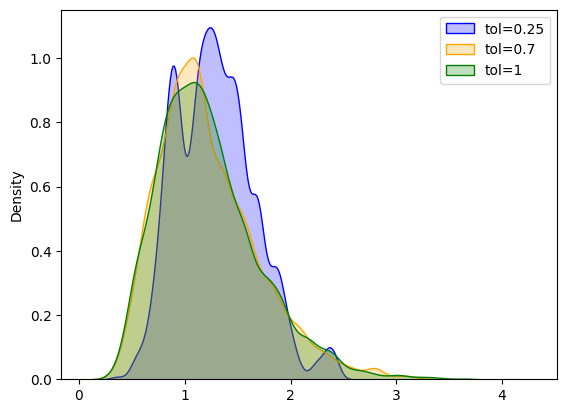

In [4]:
plot_phk_samples([sample_0_25[:, 0], sample_0_7[:, 0], sample_1[:, 0]])

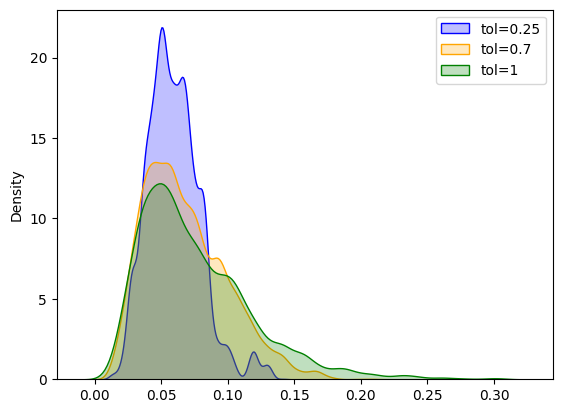

In [3]:
plot_phk_samples([sample_0_25[:, 1], sample_0_7[:, 1], sample_1[:, 1]])

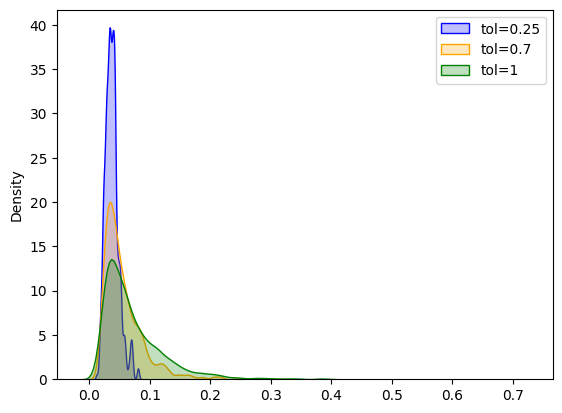

In [5]:
plot_phk_samples([sample_0_25[:, 2], sample_0_7[:, 2], sample_1[:, 2]])

In [6]:
sample_0_25 = np.load("data/ph/q5/rw_dd/ph_rw_dd_[tol=0.25]_[N=10000].npy")
sample_0_7 = np.load("data/ph/q5/rw_dd/ph_rw_dd_[tol=0.7]_[N=10000].npy")
sample_1 = np.load("data/ph/q5/rw_dd/ph_rw_dd_[tol=1]_[N=10000].npy")

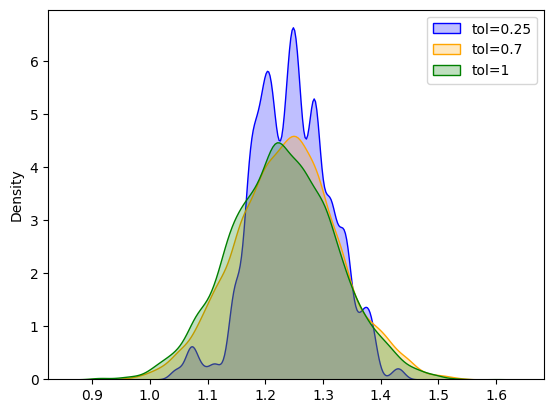

In [7]:
plot_phk_samples([sample_0_25[:, 0], sample_0_7[:, 0], sample_1[:, 0]])

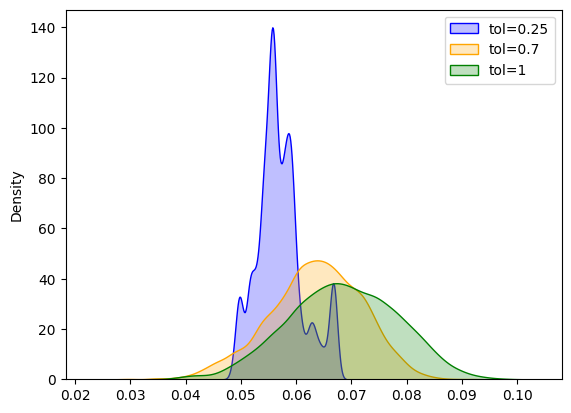

In [8]:
plot_phk_samples([sample_0_25[:, 1], sample_0_7[:, 1], sample_1[:, 1]])

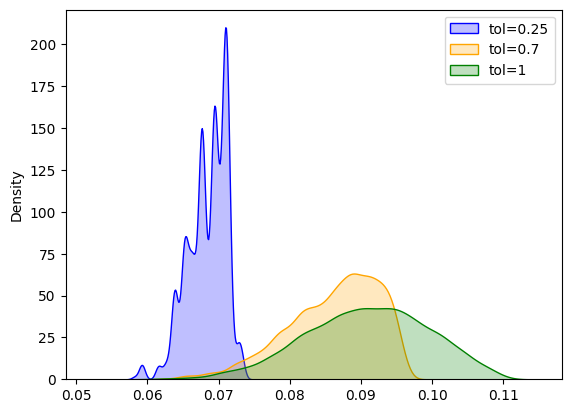

In [9]:
plot_phk_samples([sample_0_25[:, 2], sample_0_7[:, 2], sample_1[:, 2]])

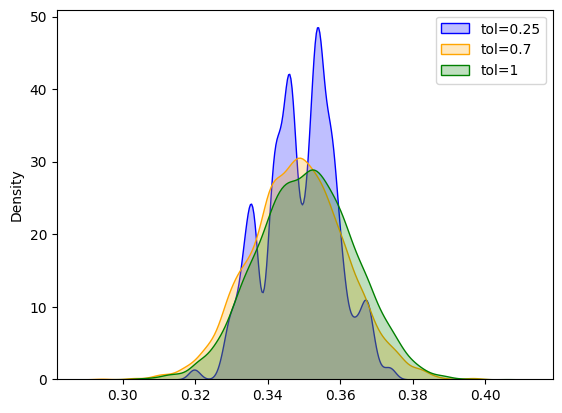

In [10]:
plot_phk_samples([sample_0_25[:, 3], sample_0_7[:, 3], sample_1[:, 3]])

In [22]:
posterior_mean_0_25 = np.mean(sample_0_25, axis=0)
posterior_mean_0_7 = np.mean(sample_0_7, axis=0)
posterior_mean_1 = np.mean(sample_1, axis=0)

print(f"Posterior mean for tolerance 0.25: {posterior_mean_0_25}")
print(f"Posterior mean for tolerance 0.7: {posterior_mean_0_7}")
print(f"Posterior mean for tolerance 1: {posterior_mean_1}")

Posterior mean for tolerance 0.25: [1.28761573 0.0591878  0.03661851 0.32075635]
Posterior mean for tolerance 0.7: [1.21906687 0.06784657 0.05567961 0.34224613]
Posterior mean for tolerance 1: [1.22205014 0.07587596 0.07197022 0.34078037]


## Question 6

In [31]:
sample_x_9 = np.load("data/ph/q6/ph_x9_data_[size=1000].npy")
sample_x_9

array([4.50349875, 2.24768837, 2.16510472, 3.87117972, 2.33744349,
       4.82576886, 3.88674169, 3.90666809, 3.26866981, 2.72849799,
       4.01111336, 2.16489017, 3.85174636, 3.24450129, 1.65959652,
       1.84334521, 5.20196828, 4.24884664, 3.46049785, 2.04969136,
       3.89427201, 3.53007766, 3.6988316 , 2.27354397, 4.50319841,
       4.55154031, 4.15999194, 3.38219426, 3.92804087, 1.61080651,
       4.20806308, 3.59383149, 2.63022816, 4.11767347, 3.64019791,
       3.40662174, 2.90555323, 4.13680468, 3.06431676, 3.74124872,
       1.95315204, 3.08841068, 3.13191441, 3.03274898, 4.84595822,
       4.2100537 , 3.41024521, 3.26350209, 4.32808892, 2.80311176,
       2.66841492, 2.38491588, 3.99103508, 3.50308002, 3.51473244,
       3.29499704, 4.31308147, 3.18973201, 2.61806531, 2.82945518,
       2.73651481, 4.08178013, 4.13072779, 2.66578514, 3.95613578,
       2.97561158, 2.4680065 , 2.87114489, 3.66999144, 3.67987129,
       2.98281814, 3.58652529, 3.72658748, 3.6929913 , 4.59567

/var/folders/rs/c9bqjyq95q59ngc5v1t0gz_00000gn/T/ipykernel_4797/721907401.py:16: RuntimeWarning: invalid value encountered in log
  plt.plot(x, d2.pdf(np.log((x-mu)/sigma)))
/var/folders/rs/c9bqjyq95q59ngc5v1t0gz_00000gn/T/ipykernel_4797/721907401.py:11: RuntimeWarning: divide by zero encountered in log
  d3_pdf = lambda x: (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))
/var/folders/rs/c9bqjyq95q59ngc5v1t0gz_00000gn/T/ipykernel_4797/721907401.py:11: RuntimeWarning: invalid value encountered in divide
  d3_pdf = lambda x: (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))


(1.246076730587381,
 1.1502737988572274,
 1.166871186668625,
 0.5190487278465993,
 1.4918246976412703,
 0.4858600903135478)

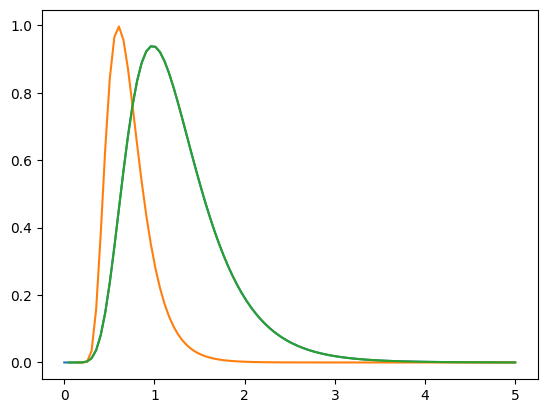

In [7]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np

mu = 0.14
sigma = 0.4

d1 = stats.lognorm(s=sigma, scale=np.exp(mu))
d2 = stats.norm(loc=mu, scale=sigma)
d3 = np.random.lognormal(mean=mu, sigma=sigma, size=100)
d3_pdf = lambda x: (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))
       / (x * sigma * np.sqrt(2 * np.pi)))

x = np.linspace(0, 5, 100)
plt.plot(x, d1.pdf(x))
plt.plot(x, d2.pdf(np.log((x-mu)/sigma)))
plt.plot(x, d3_pdf(x))
# plt.legend(['lognorm', 'norm', 'lognorm (numpy)'])
d1.mean(), np.exp(d2.mean()), d3.mean(), d1.std(), np.exp(d2.std()), d3.std()